In [1]:
import numpy as np
import csv
import pickle
from scipy import stats

import sys
sys.path.insert(1, '../')
from utils import *

In [13]:
plt.rcParams.update({'font.size': 13})

In [2]:
#dataset = 'hospital'
#dataset = 'high_school'
#dataset = 'conference'
#dataset = 'workplace'
dataset = 'pr_school'

In [3]:
weighted = True

In [4]:
mu = 0.1

In [5]:
if dataset == 'hospital':
    beta_range = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    R0_range = [1.20,1.53,1.77,2,2.22,2.38,2.56,2.7]

elif dataset == 'high_school':
    beta_range = [0.5,0.6,0.7,0.8,0.9,1.0]
    R0_range = [1.25,1.40,1.55,1.71,1.83,1.88]

elif dataset == 'workplace':
    beta_range = [0.3,0.4,0.5,0.6,0.7,0.8]
    R0_range = [1.26,1.55,1.82,2.06,2.22,2.40]

elif dataset == 'conference':
    beta_range = [0.6,0.7,0.8,0.9,1]
    R0_range = [1.21,1.37,1.49,1.60,1.74]
    
elif dataset == 'pr_school':
    beta_range = [0.12,0.15,0.18,0.21,0.24,0.27,0.3,0.33,0.36]
    R0_range = [1.40,1.65,1.97,2.11,2.31,2.48,2.68,2.84,3.01]

In [6]:
if dataset == 'hospital':
    beta_betaT_range = [(0.6,0.8),
                        (0.2,0.8),
                        (0.4,7.5),
                        (0.3,5),
                        (0.15,5),
                        (0.3,10),
                        (0.1,10),
                        (0.06,10),
                        (0.05,15),
                        (0.05,19)]
#elif dataset == 'high_school':
    
elif dataset == 'conference':
    beta_betaT_range = [#(1,12),
                        #(0.9,12),
                        (0.8,12),
                        (0.7,12),
                        (0.6,12),
                        (0.5,12),
                        (0.4,12),
                        (0.4,10),
                        (0.3,12)]  
elif dataset == 'workplace':
    beta_betaT_range = [#(0.5,6),
                        (0.5,7),
                        (0.4,7.3),
                        (0.3,6.5),
                        (0.25,6.5),
                        (0.25,7),
                        (0.2,7),
                        (0.2,7.3)]
elif dataset == 'pr_school':
    beta_betaT_range = [(0.07,7),
                        (0.1,7),
                        (0.1,5),
                        (0.2,7),
                        (0.15,5),
                        (0.2,5),
                        (0.2,3),
                        (0.2,1),
                        ]

# Load C and obtain r and s:

C is an array of weights, I need to put it in a matrix shape to compute r and s

In [7]:
def obtain_r_s_indices(C,edgelist):
    # put C in dict:
    C_dict = {}
    n = 0
    for edge in edgelist:
        C_dict[tuple(edge)] = C[n]
        C_dict[tuple(edge[::-1])] = C[n+1]
        n += 2
    # verify:
    if list(C_dict.values()) != list(C):
        print('error')
    nb_nodes = max(np.unique(list(C_dict.keys()))) + 1
    # put C_dict in matrix:
    C_mat = np.zeros((nb_nodes,nb_nodes))
    for link in C_dict:
        C_mat[link[0],link[1]] = C_dict[link]

    # receiver index:
    r = C_mat.sum(axis=0) # somma di ogni colonna
    # spreader index:
    s = C_mat.sum(axis=1) # somma di ogni riga

    return r, s

In [8]:
with open('../data/pairwise/' + dataset + '_strength_edgelist_pairwise_sorted_norm.pkl', 'rb') as f:
    edgelist = pickle.load(f)

Load simplicial

In [9]:
r_simplicial_list = []
s_simplicial_list = []
for (beta,betaT) in beta_betaT_range:
    filename = "../Simplicial_model/code/results/inf_treeSIR/CL_mean_weighted_%s_beta_%.3f_betaT_%.3f_mu_%.2f_init_1.csv"%(dataset,beta,betaT,mu)
    CL = load_C_mean(filename)
    filename = "../Simplicial_model/code/results/inf_treeSIR/CT_mean_weighted_%s_beta_%.3f_betaT_%.3f_mu_%.2f_init_1.csv"%(dataset,beta,betaT,mu)
    CT = load_C_mean(filename)
    C = CL + CT
    # verify:
    if 2*len(edgelist) != len(C):
        print('errore')
    r, s = obtain_r_s_indices(C,edgelist)
    r_simplicial_list.append(r)
    s_simplicial_list.append(s)
    

Load simple

In [10]:
r_simple_list = []
s_simple_list = []
betaT = 0
for beta in beta_range:
    filename = "../Simple_model/code/results/inf_treeSIR/CL_mean_weighted_%s_beta_%.3f_betaT_%.3f_mu_%.2f_init_1.csv"%(dataset,beta,betaT,mu)
    C = load_C_mean(filename)
    # verify:
    if 2*len(edgelist) != len(C):
        print('errore')
    r, s = obtain_r_s_indices(C,edgelist)
    r_simple_list.append(r)
    s_simple_list.append(s)
    

# Cosine similarity

### Receiver index

In [11]:
sim_r = np.full((len(beta_range),len(beta_betaT_range)),0.0)
for i in range(len(beta_range)):
    for j in range(len(beta_betaT_range)):
        sim_r[i,j] = cos_sim(r_simple_list[i],r_simplicial_list[j] )

0.9581870387964379 0.9996290255979838


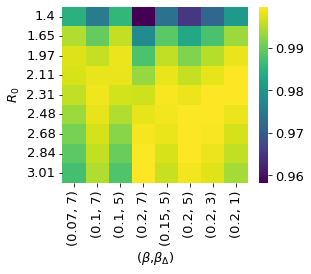

In [14]:
title='$r_i$ cosine sim.'
figname = 'figs/simplicial_simple_cos_sim_receiver_%s_mu_%.2f.pdf'%(dataset,mu)

plot_sim_different_axes(sim_r, 
                        beta_betaT_range,
                        R0_range,
                        r'($\beta$,$\beta_{\Delta}$)',
                        '$R_0$',
                        figname=figname,
                        save=True)


### Spreader index

In [15]:
sim_s = np.full((len(beta_range),len(beta_betaT_range)),0.0)
for i in range(len(beta_range)):
    for j in range(len(beta_betaT_range)):
        sim_s[i,j] = cos_sim(s_simple_list[i],s_simplicial_list[j] )

0.9746198414278667 0.9977222462505211


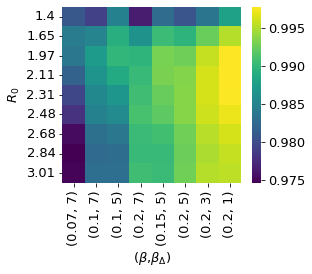

In [16]:
title='$s_i$ cosine sim.'
figname = 'figs/simplicial_simple_cos_sim_spreader_%s_mu_%.2f.pdf'%(dataset,mu)

plot_sim_different_axes(sim_s, 
                        beta_betaT_range,
                        R0_range,
                        r'($\beta$,$\beta_{\Delta}$)',
                        '$R_0$',
                        figname,
                        save=True)

# Ranking correlation

### Receiver index

In [17]:
corr_r = np.full((len(beta_range),len(beta_betaT_range)),0.0)
for i in range(len(beta_range)):
    for j in range(len(beta_betaT_range)):
        corr_r[i,j] = stats.spearmanr(np.array(r_simple_list[i]),np.array(r_simplicial_list[j])).correlation

0.9027984684777435 0.9860824309085757


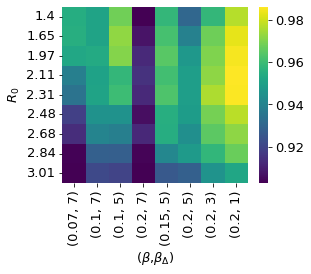

In [19]:
title='$r_i$ rank corr.'
figname = 'figs/simplicial_simple_rank_corr_receiver_%s_mu_%.2f.pdf'%(dataset,mu)

plot_sim_different_axes(corr_r, 
                        beta_betaT_range,
                        R0_range,
                        r'($\beta$,$\beta_{\Delta}$)',
                        '$R_0$',
                        figname,
                        save=True)

### Spreader index

In [20]:
corr_s = np.full((len(beta_range),len(beta_betaT_range)),0.0)
for i in range(len(beta_range)):
    for j in range(len(beta_betaT_range)):
        corr_s[i,j] = stats.spearmanr(np.array(s_simple_list[i]),np.array(s_simplicial_list[j])).correlation

0.9399874938665334 0.9938019704145695


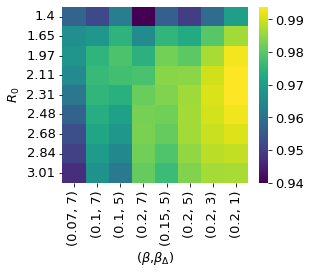

In [21]:
title='$s_i$ rank corr.'
figname = 'figs/simplicial_simple_rank_corr_spreader_%s_mu_%.2f.pdf'%(dataset,mu)

plot_sim_different_axes(corr_s, 
                        beta_betaT_range,
                        R0_range,
                        r'($\beta$,$\beta_{\Delta}$)',
                        '$R_0$',
                        figname,
                        save=True)